# Import libraries

In [1]:
import csv
import cv2
from IPython.display import clear_output
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import misc
import sys
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import yaml

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# tfe.enable_eager_execution()

# Load a sample image

In [3]:
path = '../data/nd-iris/LG2200/2009-03-03_05/05930/05930d67.tiff'
image= misc.imread(path)

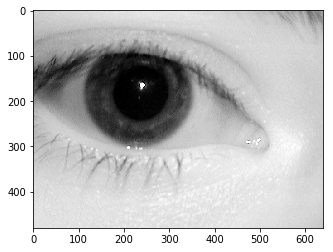

In [4]:
plt.imshow(image, cmap = cm.Greys_r)

## Crop Iris

In [5]:
def get_circle(image):
    houge_circles = lambda image, thresh: cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 2, 100.0,
                                                          param1=60, param2=thresh, 
                                                          minRadius=100, maxRadius=140)
    for thresh in range(125, 155):
        circles = houge_circles(image, thresh)
        
        if circles is not None and len(circles[0]) == 1:
            return np.uint16(np.around(circles[0][0]))

    return None

In [6]:
get_limits_from_cricle = lambda circle: ((circle[1] - circle[2], circle[1] + circle[2]), 
                                         (circle[0] - circle[2], circle[0] + circle[2]))

In [7]:
def get_iris(image, size=(250, 250), display=False):
    output = image.copy()
    circle = get_circle(output)
    limits = get_limits_from_cricle(circle)
    
    if display:
        cv2.circle(output,(circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    
    # Add extra padding around the roi 
    offset_x = (size[0] - 2 * circle[2]) // 2
    offset_y = (size[1] - 2 * circle[2]) // 2
    
    output = output[limits[0][0] - offset_x:limits[0][1] + offset_x,
                    limits[1][0] - offset_y:limits[1][1] + offset_y] 
    
    if display:
        plt.figure()
        plt.imshow(output, cmap = cm.Greys_r)
    
    return output

(250, 250)

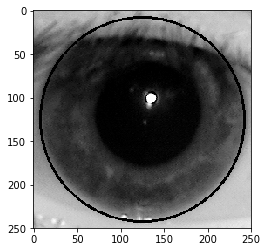

In [8]:
get_iris(image, display=True).shape

## Re-scale images

In [9]:
scale_image = lambda image: image * (1. / 255) - 0.5

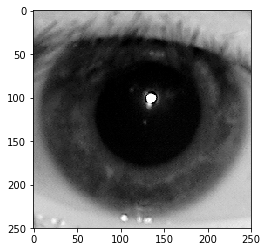

In [10]:
scaled_image = scale_image(get_iris(image))
plt.imshow(scaled_image, cmap = cm.Greys_r)

## Reading the specs file

In [ ]:
def create_dictionary(base_path):
    file_dict = {}
    sensors = ["LG2200", "LG4000"] 
    
    for sensor in sensors:
        sensor_data_path = os.path.join(base_path, sensor)
        for session in os.listdir(sensor_data_path):
            session_data_path = os.path.join(sensor_data_path, session)
            for user in os.listdir(session_data_path):
                user_data_path = os.path.join(session_data_path, user)
                file = open(os.path.join(user_data_path, "{}.txt".format(user)))
                specs = csv.reader(file, delimiter="\t")
                for row in specs:
                    if row == []:
                        if _id not in file_dict.keys():
                            file_dict[_id] = []
                        file_dict[_id].append(image_path)
                    elif row[0] == 'sequenceid':
                        image_path = os.path.join(user_data_path, "{}.tiff".format(row[2]))
                    elif row[0] == 'eye':
                        _id = int(user) if row[2] == 'Right' else int(user) + 10000
    
    yaml_file = open(os.path.join(base_path, "nd-iris-file-dict.yml"), "w")
    yaml.dump(file_dict, yaml_file)

In [ ]:
create_dictionary("../data/nd-iris")

## Crate an generators to fetch image paths

In [11]:
def get_image_paths(file_dict_path):
    f = open(file_dict_path, 'r')
    file_dict = yaml.load(f)
    
    for _id, image_paths in file_dict.items():
        for image_path in image_paths:
            yield (_id, image_path)

# Write to TFRecords

In [12]:
# TFRecord helper functions
get_tfr_writer = lambda filename: tf.python_io.TFRecordWriter(filename)
_int64_feature = lambda value: tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
_bytes_feature = lambda value: tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [13]:
class ShardedTFRecordWriter(object):
    def __init__(self, file_path, filename, samples_per_file=10000):
        self.file_path = file_path
        self.filname = filename
        self.samples_per_file = samples_per_file
        self.count = 0
        
        self.writer = None
        
    def get_file_name(self):
        return "{}-{}.tfrecords".format(os.path.join(self.file_path, self.filname), 
                                        self.count // self.samples_per_file)
        
    def write(self, image, label):
        feature = {'label': _int64_feature(label),
                   'image': _bytes_feature(tf.compat.as_bytes(image.tostring()))}
        
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Update writer
        if self.writer is None or self.count % self.samples_per_file == 0:
            self.close()
            self.writer = get_tfr_writer(self.get_file_name())
        
        # Serialize to string and write on the file
        self.writer.write(example.SerializeToString())
        
        # Increment count
        self.count += 1
        
    def close(self):
        if self.writer is not None:
            self.writer.close()

In [14]:
def create_tfrecords(data, samples_per_file=10000, split_ratios=[0.7, 0.15, 0.15], log_file="create_tfrecords.logs"):    
    # Open log file
    log_file = open(log_file, 'a')
    
    # Create tfr writers
    splits = ['train', 'test', 'val']
    writers = {x: ShardedTFRecordWriter('../data/nd-iris/tfrecords',
                                        'nd-iris-{}'.format(x),
                                         samples_per_file) for x in splits}
    
    get_random_split = lambda: splits[np.random.multinomial(1, split_ratios).argmax()]
  
    for i, (label, image_path) in enumerate(data):
        # Process data
        try:
            image = scale_image(get_iris(misc.imread(image_path)))
        except Exception as e:
            log_file.write("{}:\n\t{}\n".format(image_path, str(e)))
            continue
        
        if image.shape != (250, 250):
            log_file.write("{}:\n\tInconsistant image size: {}\n".format(image_path, image.shape))
            continue
        
        image = image.astype(np.float32)
        label = np.asarray(label, dtype=np.int64)
        
        # Write to randomly choosen split
        split = get_random_split()
        writers[split].write(image, label)
        
        if i % 100 == 0:
            clear_output()
            print("Writing to {} image #{}: {}".format(split, i, image_path))

    log_file.close()
    map(lambda x: writers[x].close(), splits)

In [15]:
create_tfrecords(get_image_paths("../data/nd-iris/nd-iris-file-dict.yml"))

Writing to train image #146900: ../data/nd-iris/LG2200/2010-04-13_15/06266/06266d8.tiff


# Load images from the TFRecords file

In [16]:
def decode(serialized_example):
    """Parses an image and label from the given `serialized_example`."""
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length 250 * 250) to a float64 tensor with shape
    # [250 * 250].
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [250, 250])

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int64)

    return image, label

In [17]:
def inputs(filename, batch_size, num_epochs):
    """Reads input data num_epochs times.
    Args:
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
       train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, 350, 250]
      in the range [-0.5, 0.5].
    * labels is an int64 tensor with shape [batch_size] with the true label.

    This function creates a one_shot_iterator, meaning that it will only iterate
    over the dataset once. On the other hand there is no special initialization
    required.
    """
    if not num_epochs:
        num_epochs = None
    
    filename = os.path.join("./", filename)

    with tf.name_scope('input'):
        # TFRecordDataset opens a binary file and reads one record at a time.
        # `filename` could also be a list of filenames, which will be read in order.
        dataset = tf.data.TFRecordDataset(filename)

        # The map transformation takes a function and applies it to every element
        # of the dataset.
        dataset = dataset.map(decode)

        # The shuffle transformation uses a finite-sized buffer to shuffle elements
        # in memory. The parameter is the number of elements in the buffer. For
        # completely uniform shuffling, set the parameter to be the same as the
        # number of elements in the dataset.
        dataset = dataset.shuffle(1000 + 3 * batch_size)

        dataset = dataset.repeat(num_epochs)
        dataset = dataset.batch(batch_size)

        iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [75]:
def show_samples_from_tfr(filename):
    """Show sample images from a TFRecords file."""
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Input images and labels.
        image_batch, label_batch = inputs(
            filename=filename, batch_size=32, num_epochs=1)

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        
        # Create a session for running operations in the Graph.
        with tf.Session() as sess:
            # Initialize the variables (the trained variables and the
            # epoch counter).
            sess.run(init_op)
            image, label = sess.run([image_batch, label_batch])
            fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))
            for j in range(32):
                row = j // 8
                col = j % 8
                axes[row, col].axis("off")
                axes[row, col].imshow(image[j], cmap = cm.Greys_r)
                axes[row, col].set_title(label[j])
            plt.show()

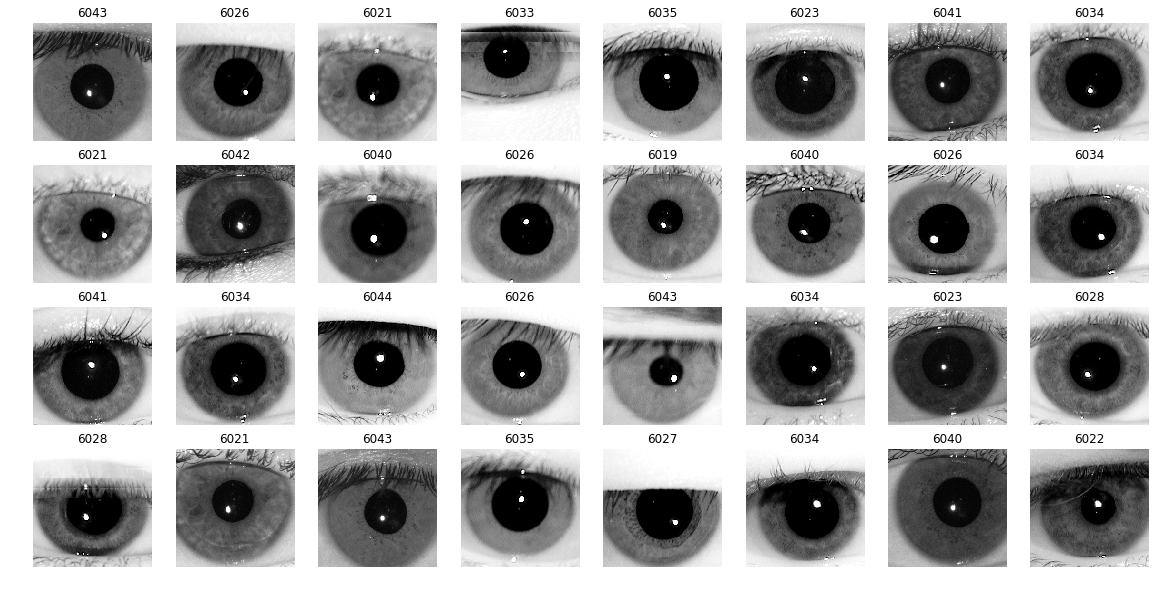

In [100]:
filename = '../data/nd-iris/tfrecords/nd-iris-train-4.tfrecords'
show_samples_from_tfr(filename)

In [ ]:
record_iterator = tf.python_io.tf_record_iterator(path='../data/nd-iris/tfrecords/nd-iris-train-1.tfrecords')

i = 0
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    features = example.features.feature
    image = tf.decode_raw(features['image'].bytes_list.value[0], tf.float32)
    image = tf.reshape(image, [250, 250])
    if i == 90:
        plt.imshow(image, cmap = cm.Greys_r)
    if i > 100:
        break
    i += 1